In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd

In [2]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulations import plot_simulations, create_data_input

In [5]:
purity = .99
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, purity = purity, coverage = coverage, genome_size = 30000000)
snp,snv = simulate_data(segs)
data_input, snp, snv = create_data_input(snp, snv)

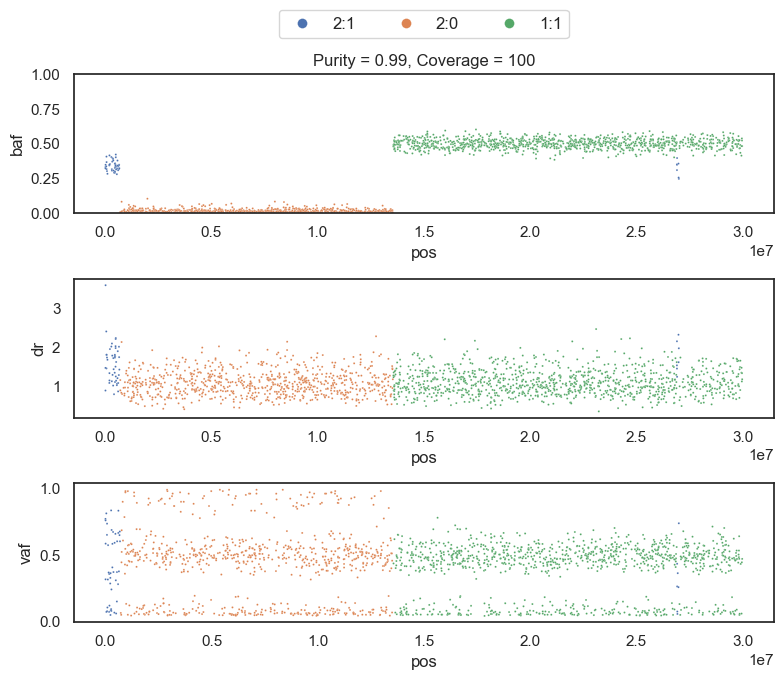

In [6]:
plot_simulations(snp, snv, purity, coverage)

In [5]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss
from locate.utils import plot_results_simulations

In [6]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1]})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [7]:
ll = locate.run(steps = 800, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 7386.535932939  :   0%|          | 0/800 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 4035.083113575  : 100%|██████████| 800/800 [00:13<00:00, 61.39it/s]


Done!


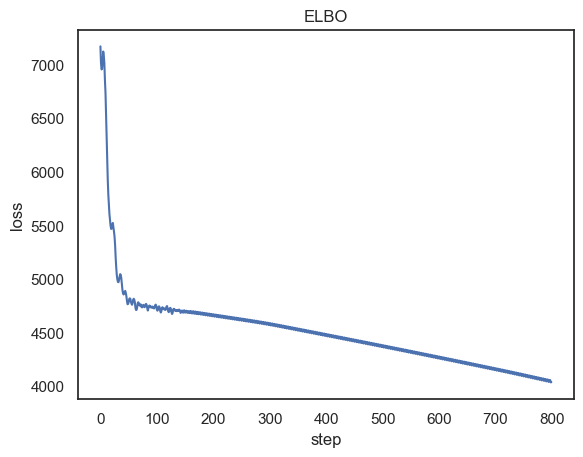

In [8]:
plot_loss(ll[0])


In [9]:
params = locate.learned_parameters_Clonal()

In [10]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

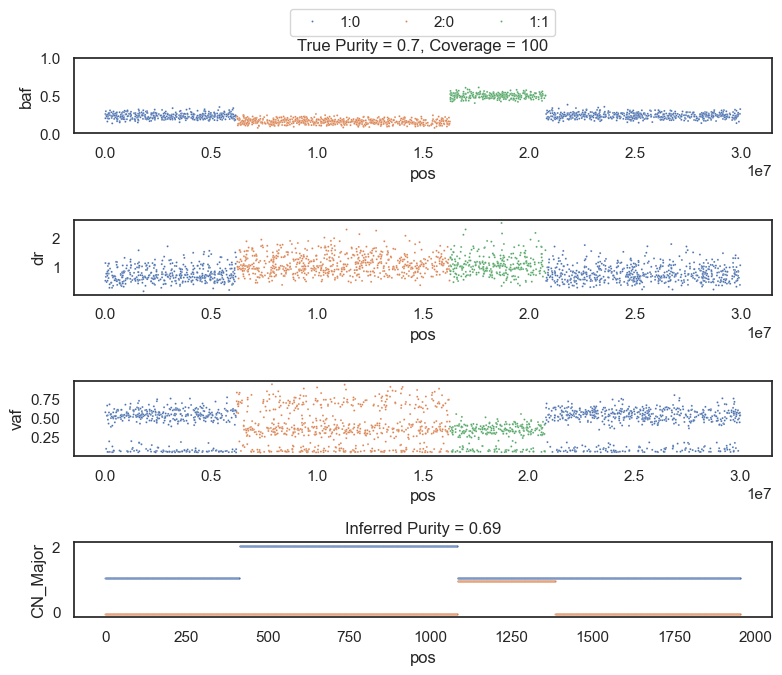

In [11]:
plot_results_simulations(snp, snv, res, params, purity, coverage)